In [1]:
import numpy
import math
from utils import *
from matplotlib import pyplot as plt
from frc3223_azurite.motors import *
from frc3223_azurite import motors
from frc3223_azurite import inertials
import frccontrol
import control

from flywheel import FlywheelSimulation

In [2]:
print("""
A flywheel is attached to a motor system. a spherical gamepiece enters the flywheel channel and 
is driven through the channel until the point where it leaves the channel.

We specify when the gamepiece enters the channel, where it enters,  and where it exits.
We specify the usual physical properties of the gamepiece and also the coefficient of friction between the 
gamepiece and the flywheel and between the gamepiece and the channel wall.
""")


A flywheel is attached to a motor system. a spherical gamepiece enters the flywheel channel and 
is driven through the channel until the point where it leaves the channel.

We specify when the gamepiece enters the channel, where it enters,  and where it exits.
We specify the usual physical properties of the gamepiece and also the coefficient of friction between the 
gamepiece and the flywheel and between the gamepiece and the channel wall.



In [3]:
class Flywheel(frccontrol.System):
    def __init__(self, dt):
        state_labels = [
            ("position", "m"),
            ("velocity", "m/s"),
        ]
        u_labels = [("voltage", "V")]
        self.set_plot_labels(state_labels, u_labels)
        u_min = numpy.matrix([[-12.0]])
        u_max = numpy.matrix([[12.0]])
        
        frccontrol.System.__init__(self, u_min, u_max, dt, numpy.zeros((2, 1)), numpy.zeros((1, 1)))
        
    def create_model(self, inputs, states):
        self.radius = r = inch_to_meter(.5625)
        self.j = j = inertials.solid_cylinder(0.12, r) # moment of inertia of sprocket
        self.m1=m1 = lbs_to_kg(1)
        self.m2 = m2 = lbs_to_kg(0)
        self.spring_force = lbs_to_N(5.0)
        self.motor_system = ms = motors.MotorSystem(motor=motors.neo, motor_count=1, gearing_ratio=10)
        
        
        
        self.Ka = Ka = j * ms.motor.resistance() / (r * ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        self.Kv = Kv = ms.motor.kspeed() * ms.gearing_ratio / r
        self.Ks = Ks = ms.motor.resistance() * r * (g * m1 + self.spring_force) / (ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        print("ks: %f" % Ks)
        print("kv: %f" % Kv)
        print("ka: %f" % Ka)
        A = numpy.array([
            [0, 1],
            [0, -Kv/Ka],
        ])
        print("A continuous: ", A)
        B = numpy.array([
            [0],
            [1/Ka],
        ])
        print("B continuous: ", B)
        C = numpy.array([
            [1, 0],
        ])
        D = numpy.zeros(shape=(1,1))
        
        model = control.ss(A, B, C, D)
        
        return model
    
    def design_controller_observer(self):
        q = [0.12, 0.4]
        r = [12.0]
        self.design_lqr(q, r)
        self.design_two_state_feedforward(q, r)

        q_pos = 0.15
        q_vel = 1.0
        r_pos = 0.0001
        self.design_kalman_filter([q_pos, q_vel], [r_pos])
        #self.Ainv = numpy.linalg.inv(self.sysd.A)
        self.Ainv = numpy.eye(self.sysd.A.shape[0])
        
    def init(self, state):
        state.u = numpy.zeros(shape=(self.sysd.B.shape[1], 1))
        state.u_offset = numpy.zeros(shape=state.u.shape)
        #self.u_max[0, 0] -= self.Ks
        #self.u_min[0, 0] -= self.Ks
        state.u_offset[0,0] = self.Ks
        state.y = numpy.zeros((self.sysd.C.shape[0], 1))
        state.r = numpy.zeros((self.sysd.A.shape[0], 1))
        state.x_hat = numpy.zeros((self.sysd.A.shape[0], 1))
        #state.Ainv = numpy.linalg.inv(self.sysd.A)
        state.Ainv = numpy.eye(self.sysd.A.shape[0])

    def update_input(self, state, next_r):
        state.u = self.K @ (state.r - state.x_hat)
        uff = self.Kff @ (next_r  - self.sysd.A @ state.r)
        state.r = next_r
        state.u = numpy.clip(state.u + uff - state.u_offset, self.u_min, self.u_max)

    def periodic(self, state, setpoint):
        setpoint_pos = setpoint
        state.x_hat += self.kalman_gain @ (state.y - self.sysd.C @ state.x_hat - self.sysd.D @ state.u)
        self.update_input(state, numpy.array([[setpoint_pos, 0]]).T)
        vp = (state.u[0,0] + self.Ks * 0) / state.voltage
        state.motor.set(vp)
        state.y[0,0] = state.velocity_radps
        state.x_hat = self.sysd.A @ state.x_hat + self.sysd.B @ state.u
    
flywheel = Flywheel(0.02)

ks: 0.175999
kv: 14.130385
ka: 0.000396
A continuous:  [[ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -3.57140092e+04]]
B continuous:  [[   0.        ]
 [2527.46184505]]


entered channel, t=0.500000
exited channel, t=0.700000


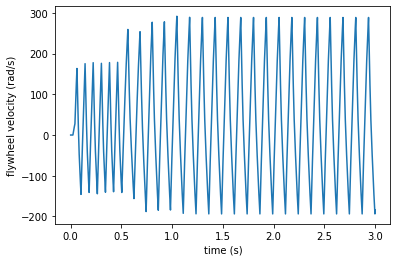

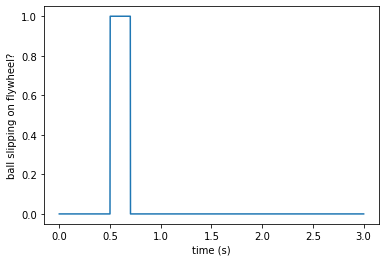

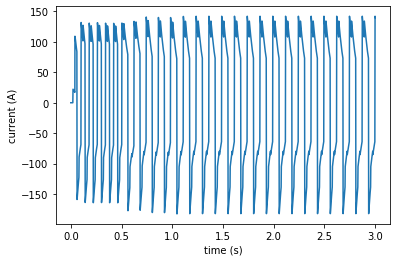

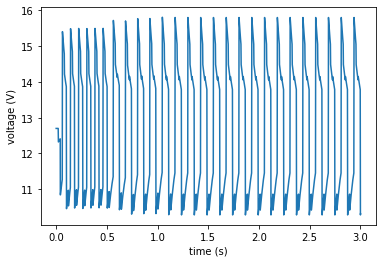

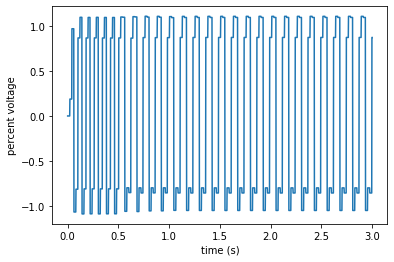

In [5]:
def ss_periodic(state):
    flywheel.periodic(state, setpoint=1)
    
def ss_init(state):
    flywheel.init(state)

def const_periodic(state):
    state.motor.set(0.5)

motor_system = MotorSystem(motor=cim, motor_count=1, gearing_ratio=1)
sim = FlywheelSimulation(
    flywheel_radius_m=inch_to_meter(2),
    flywheel_initial_velocity_radps=0,
    flywheel_mass_kg=0.2,
    
    flywheel_ball_static_friction=0.1,
    flywheel_ball_kinetic_friction=0.75,
    
    channel_ball_static_friction=0.07,
    channel_ball_kinetic_friction=0.0053,
    
    
    entry_time=0.5,
    exit_time=0.7,
    ball_force=lbs_to_N(1),
    entry_position_rad=math.radians(155),
    exit_position_rad=math.radians(12),
    init=ss_init,
    periodic=ss_periodic,
    motor_system=motor_system)
sim.run_simulation(dt=0.001)

plt.plot(sim.ts, sim.wvs)
plt.xlabel("time (s)")
plt.ylabel("flywheel velocity (rad/s)")
plt.show()



plt.plot(sim.ts, sim.fslips)
plt.xlabel("time (s)")
plt.ylabel("ball slipping on flywheel?")
plt.show()




plt.plot(sim.ts, sim.currents)
plt.xlabel("time (s)")
plt.ylabel("current (A)")
plt.show()

plt.plot(sim.ts, sim.voltages)
plt.xlabel("time (s)")
plt.ylabel("voltage (V)")
plt.show()


plt.plot(sim.ts, sim.voltageps)
plt.xlabel("time (s)")
plt.ylabel("percent voltage")
plt.show()